In [36]:
import os
import time
import json
import re

import numpy as np
import matplotlib.pyplot as plt

from model_funcs import *

## Extract features

### Data we are going to use
$X$ - observations - logarithmically compressed chroma features for all songs (size Nx12) 

$X_{small}$ - take only first 100 of each song

$X_{adjusted}$ - corresponding to only those chord symbols retrieved

$\{\tau_i, C_i\}$ - onsets and chords for each song

$y$ - chord annotation indices for chords succesfully retrieved

In [37]:
dataset_path = 'project_data/JAAH-master/'
features_path = dataset_path + 'features/'
annotations_path = dataset_path + 'annotations/'


In [38]:
db_file = open(features_path + 'db.json', 'r')
songs = json.load(db_file)
db_file.close()

In [128]:
def compress_log(values, gamma=100):
    '''values is a np array, 
    gamma is the compression constant'''
    return np.log(np.ones(values.shape) + gamma*values)


def get_chords_from_noted(parts_list):
    t = []
    C = []
    
    for i, part in enumerate(parts_list):
        if len(t) > 0:
            assert part["beats"][0] > t[-1]
        times = part["beats"]
        
        chord_str = "".join(part["chords"])
        measures = re.split('\|{1,2}',chord_str)[1:-1]
        chords = []
        for m in measures:
            chord_set = re.split(' ', m)[:-1]
            if len(chord_set) == 1:
                chord_set = 4 * chord_set
            elif len(chord_set) == 2:
                chord_set = 2 * [chord_set[0]] + 2 * [chord_set[1]]
            chords.extend(chord_set)
            
        #if i + 1 == len(parts_list) and len(times) > len(chords):
            #times = times[:len(chords)]
            
        if len(times) != len(chords):
            print("Stopped at part " + str(i) + "/" + str(len(parts_list)))
            break
        else:
            t.extend(times)
            C.extend(chords)
    
    t = np.array(t)
    C = np.array(C)
    return t, C


#Testing purposes
song_name = "blues_for_alice"
if os.path.isfile(annotations_path + song_name + '.json'):
    json_file = open(annotations_path + song_name + '.json')
    noted_obj = json.load(json_file)
    json_file.close()
    
t, C = get_chords_from_noted(noted_obj["parts"])
print(C)


Stopped at part 6/7
['F' 'F' 'F' 'F' 'Ab:7' 'Ab:7' 'Ab:7' 'Ab:7' 'C#:7' 'C#:7' 'C#:7' 'C#:7'
 'F#:(3,5,b7,#11)' 'F#:(3,5,b7,#11)' 'F#:(3,5,b7,#11)' 'F#:(3,5,b7,#11)'
 'F:maj7' 'F:maj7' 'F:maj7' 'F:maj7' 'E:hdim7' 'E:hdim7' 'A:7' 'A:7'
 'D:min7' 'D:min7' 'G:7' 'G:7' 'C:min7' 'C:min7' 'F:7' 'F:7' 'Bb:7' 'Bb:7'
 'Bb:7' 'Bb:7' 'Bb:min7' 'Bb:min7' 'Eb:7' 'Eb:7' 'A:min7' 'A:min7' 'D:7'
 'D:7' 'Ab:min7' 'Ab:min7' 'Db:7' 'Db:7' 'G:min7' 'G:min7' 'G:min7'
 'G:min7' 'C:7' 'C:7' 'C:7' 'C:7' 'F:7' 'F:7' 'A:min7' 'A:min7' 'G:min7'
 'G:min7' 'C:7' 'C:7' 'F:maj7' 'F:maj7' 'F:maj7' 'F:maj7' 'E:hdim7'
 'E:hdim7' 'A:7' 'A:7' 'D:min7' 'D:min7' 'G:7' 'G:7' 'C:min7' 'C:min7'
 'F:7' 'F:7' 'Bb:7' 'Bb:7' 'Bb:7' 'Bb:7' 'Bb:min7' 'Bb:min7' 'Eb:7' 'Eb:7'
 'A:min7' 'A:min7' 'D:7' 'D:7' 'Ab:min7' 'Ab:min7' 'Db:7' 'Db:7' 'G:min7'
 'G:min7' 'G:min7' 'G:min7' 'C:7' 'C:7' 'C:7' 'C:7' 'F:7' 'F:7' 'A:min7'
 'A:min7' 'G:min7' 'G:min7' 'C:7' 'C:7' 'F:maj7' 'F:maj7' 'F:maj7'
 'F:maj7' 'E:hdim7' 'E:hdim7' 'A:7' 'A:7' 'D:min

In [129]:

def frame_chords(n_of_frames, feature_rate, time_vector, chord_vector):
    C_t = []
    pointer = 0
    
    for n in range(n_of_frames):
        t = n*1.0/feature_rate
        t_mid = (n+0.5)/feature_rate
        
        if np.abs(time_vector[pointer] - t_mid) <= 0.5/feature_rate:
            C_t.append(chord_vector[pointer])
            pointer += 1
        else:
            if pointer == 0:
                C_t.append('N')
            else:
                C_t.append(chord_vector[pointer-1])
            
    return C_t

def indexize_chords(chord_vector):
    note_names = ['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B']
    mapping = {
        'C' : 0,
        'C#' : 1,
        'Db' : 1,
        'D' : 2,
        'D#' : 3,
        'Eb' : 3,
        'E' : 4,
        'F' : 5,
        'F#' : 6,
        'Gb' : 6,
        'G' : 7,
        'G#' : 8,
        'Ab' : 8,
        'A' : 9,
        'A#' : 10,
        'Bb' : 10,
        'B' : 11
    }
    indices = []
    for chord_str in chord_vector:
        if re.match('N', chord_str):
            indices.append(12)
        else:
            indices.append(mapping[chord_str.split(":")[0]])
            
    return indices

F = frame_chords(int(t[-1]*song_dict["feature_rate"])-10, song_dict["feature_rate"], t, C)

I = indexize_chords(F)

print(I)

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 3, 3, 3, 3, 

In [133]:
song_data = []
X = np.zeros((0,12))
X_small = np.zeros((0,12))
X_adjusted = np.zeros((0,12))
y = np.zeros((0))
starting_points = []
idx = 0
for song_obj in songs[:14]:
    song_name = song_obj['nnls_chroma']['path'].split('.')[0]
    step_size = int(song_obj['nnls_chroma']['step_size'])
    sample_rate = int(song_obj['nnls_chroma']['sample_rate'])
    feature_rate = sample_rate * 1.0 / step_size
    
    song_dict = {
                "song_name" : song_name,
                "step_size" : step_size,
                "sample_rate" : sample_rate,
                "feature_rate" : feature_rate
    }
    print(str(idx) + " " + song_name)
    
    if os.path.isfile(features_path + song_name + '.csv'):
        chroma_file = open(features_path + song_name + '.csv')
        chroma_raw = chroma_file.readlines()
        chroma_file.close()
    
    song_dict["starting_point"] = X.shape[0]
    
    song_chroma = []
    for i in range(len(chroma_raw)):
        song_chroma.append([
                            float(ele) for ele in 
                            chroma_raw[i].strip().split(',')[1:]
        ])
    
    song_chroma = compress_log(np.array(song_chroma), gamma=10)
    
    
    
    # Collect annotations
    if os.path.isfile(annotations_path + song_name + '.json'):
        json_file = open(annotations_path + song_name + '.json')
        noted_obj = json.load(json_file)
        json_file.close()
     
    t, C = get_chords_from_noted(noted_obj.pop("parts"))
    if len(t) > 2:
        frames_retrieved = len(t)
        t_of_last_retrieval = t[-1] 
        frames_used = int(t[-1]*feature_rate)-2 
        F = frame_chords(frames_used, feature_rate, t, C)
        chord_indices = indexize_chords(F)
        assert len(chord_indices) == frames_used
        y = np.concatenate((y, np.array(chord_indices)))
    else:
        frames_retrieved = 0
        frames_used = 0
    
    song_dict.update(noted_obj)
    song_data.append(song_dict)
    
    X = np.concatenate((X, song_chroma))
    X_small = np.concatenate((X_small, song_chroma[:100]))
    X_adjusted = np.concatenate((X_adjusted, song_chroma[:frames_used]))
    
    idx += 1
    


0 i_gotta_right_to_sing_the_blues
Stopped at part 3/4
1 black_water_blues
Stopped at part 2/5
2 ko-ko(ellington)
Stopped at part 6/7
3 haig_and_haig
Stopped at part 9/11
4 blues_for_alice
Stopped at part 6/7
5 for_dancers_only
Stopped at part 6/7
6 honeysuckle_rose
Stopped at part 1/6
7 maple_leaf_rag(hyman)
Stopped at part 0/1
8 maple_leaf_rag(braxton)
Stopped at part 0/2
9 in_a_mellotone
Stopped at part 3/4
10 airegin
Stopped at part 5/8
11 giant_steps
Stopped at part 9/11
12 harlem_congo
Stopped at part 8/9
13 bags_groove
Stopped at part 0/9


C
(12,)


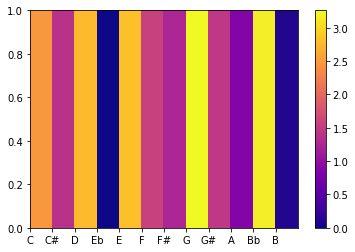

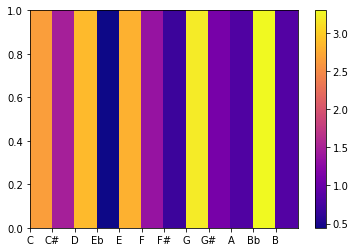

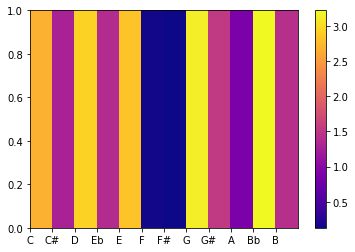

[[ 1.15159845e+00 -2.04389063e-01 -4.90286305e-02  2.53843637e-02
   3.46689831e-02  8.76588544e-02 -7.27955935e-02  7.95375711e-02
   3.23470553e-02 -1.03701577e-01 -8.16970385e-02 -9.57087605e-02]
 [-2.04389063e-01  1.12950635e+00 -1.08969789e-01 -2.10165958e-01
   8.15168682e-02  8.08862561e-02  5.17876906e-02  1.24888270e-01
  -4.68231180e-02  1.12126218e-02  5.35725813e-02 -3.49589994e-02]
 [-4.90286305e-02 -1.08969789e-01  1.08432062e+00 -2.21607572e-01
  -1.03995457e-01  6.49942524e-02 -6.27769976e-02  8.35989178e-02
  -1.39871273e-02  1.28786138e-03  2.06406732e-01  3.57478780e-02]
 [ 2.53843637e-02 -2.10165958e-01 -2.21607572e-01  1.24263278e+00
  -2.61259699e-01 -2.05974404e-01  2.08015538e-01  5.00690697e-02
   2.55559081e-01 -1.11042449e-01  1.60599852e-01  4.62890825e-03]
 [ 3.46689831e-02  8.15168682e-02 -1.03995457e-01 -2.61259699e-01
   1.00826590e+00 -5.50079597e-02 -1.08074764e-01  2.43009767e-02
  -2.41914334e-02  1.51564243e-01 -5.94350523e-02  8.81296671e-02]
 [ 8.

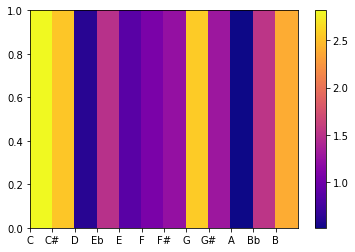

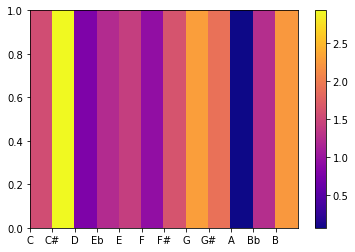

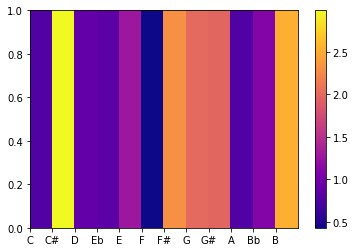

[[ 1.22319154e+00 -9.41982532e-02 -1.18951361e-01  7.72354033e-02
   1.40486405e-01  3.21016194e-01  9.12097889e-02  1.01201352e-01
   2.16660327e-01 -2.39921158e-02 -6.66810496e-02 -2.21292490e-02]
 [-9.41982532e-02  1.20107116e+00 -8.24023769e-02 -9.78082075e-02
   1.17862559e-01  2.27576804e-01  2.30168071e-01  1.47043993e-01
   1.70415699e-01  1.27439386e-01  1.87898021e-01 -1.04025652e-02]
 [-1.18951361e-01 -8.24023769e-02  1.21712775e+00 -1.60162993e-01
   1.12641090e-03  1.37047540e-01  7.07717643e-02  1.47023440e-01
  -4.66352653e-03  9.84403281e-02  1.62552985e-01  2.17973102e-01]
 [ 7.72354033e-02 -9.78082075e-02 -1.60162993e-01  1.49676880e+00
  -9.88055166e-02 -2.97075225e-01  9.27221963e-02 -3.66399995e-03
   5.31338478e-01  9.27529239e-02  7.08743129e-02 -4.66804133e-02]
 [ 1.40486405e-01  1.17862559e-01  1.12641090e-03 -9.88055166e-02
   1.05976220e+00 -7.90563528e-03 -2.31358800e-02  8.71554724e-02
   9.24497820e-02  1.61490545e-01  1.70301919e-01  1.71215433e-01]
 [ 3.

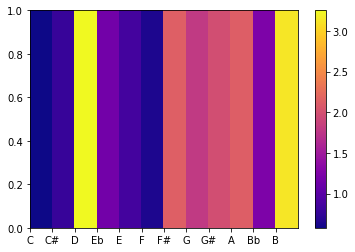

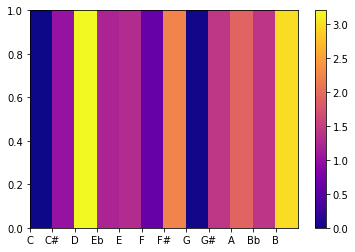

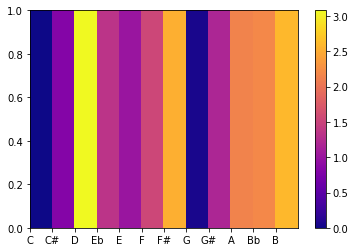

[[ 1.23974233 -0.06428135 -0.13515399  0.03249209 -0.04417916  0.26313125
   0.02038214 -0.01483289  0.18835105 -0.15388937 -0.02717478 -0.17113026]
 [-0.06428135  1.05177842 -0.1909501  -0.04455904 -0.02451129  0.20473928
   0.20745995 -0.02391105  0.06692369  0.05759719  0.08944542  0.01613068]
 [-0.13515399 -0.1909501   1.19722935 -0.25510719  0.05189463  0.09798985
  -0.11258134  0.2373322   0.09874996  0.06602937 -0.07339347  0.04813462]
 [ 0.03249209 -0.04455904 -0.25510719  1.30454262 -0.21523459 -0.167775
   0.25416013 -0.03897487  0.20413273  0.02075489  0.26628375  0.01589937]
 [-0.04417916 -0.02451129  0.05189463 -0.21523459  1.08713848 -0.20465114
  -0.08767801  0.06225582 -0.11032219  0.32891812  0.10147108  0.11550199]
 [ 0.26313125  0.20473928  0.09798985 -0.167775   -0.20465114  1.18955943
  -0.20097503 -0.10181518  0.142091   -0.0039386   0.00449425  0.00663257]
 [ 0.02038214  0.20745995 -0.11258134  0.25416013 -0.08767801 -0.20097503
   1.32510238 -0.22693074 -0.00495

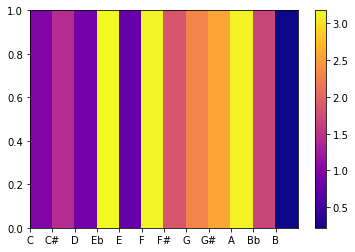

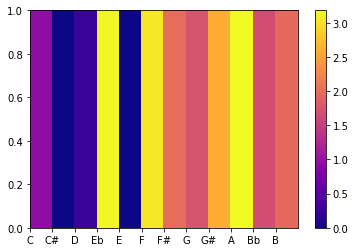

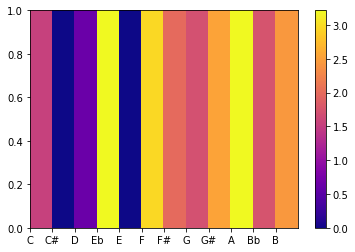

[[ 1.31908813e+00 -1.70606455e-01  5.22853804e-03  2.96725649e-01
  -3.07855337e-01  2.74547541e-01 -2.17805593e-02  3.01589765e-02
   3.10262752e-01 -2.08083750e-01  1.80193385e-02 -1.35893604e-01]
 [-1.70606455e-01  1.17609675e+00 -1.89240245e-01 -1.82586549e-01
   6.79728526e-02  1.28175166e-01  7.82297237e-02  1.07800030e-01
   6.70019498e-02  2.19120260e-01  1.30372099e-01 -6.63328118e-02]
 [ 5.22853804e-03 -1.89240245e-01  1.20571337e+00 -1.25954406e-01
  -1.11889801e-01  1.08965600e-01  1.53128274e-02  2.10301165e-01
  -1.09748897e-01  6.25745114e-02  1.09335228e-01  3.77574448e-02]
 [ 2.96725649e-01 -1.82586549e-01 -1.25954406e-01  1.49874146e+00
  -3.73273232e-01  1.84786378e-02  8.82250320e-03  3.28833364e-02
   4.04422396e-01 -3.15198512e-01  2.67437225e-01 -7.30411562e-02]
 [-3.07855337e-01  6.79728526e-02 -1.11889801e-01 -3.73273232e-01
   1.35537985e+00 -2.52261994e-01  1.27014214e-01  6.54353904e-04
   1.42497337e-02  4.31891165e-01 -1.86343804e-01  2.96820736e-01]
 [ 2.

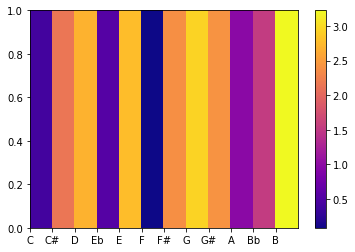

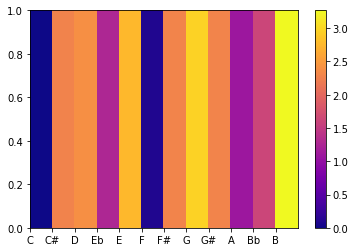

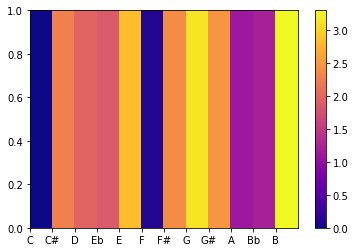

[[ 1.1771692  -0.0380454  -0.04367875 -0.06593499  0.08847887  0.20112059
  -0.17423401 -0.00464769  0.09405818 -0.02253363 -0.06163453 -0.19246669]
 [-0.0380454   1.07297175 -0.29308199 -0.24329914  0.36255076 -0.12920116
   0.0480091   0.23656745 -0.08489109  0.12545513 -0.08242131  0.11750211]
 [-0.04367875 -0.29308199  1.17552928 -0.07482595 -0.38866211  0.15877288
  -0.04518992  0.00471457  0.07816289 -0.22346944  0.40032962 -0.23693642]
 [-0.06593499 -0.24329914 -0.07482595  1.06524948 -0.32828057  0.03198696
   0.11482109 -0.04301453  0.1340125   0.0668258   0.08489167 -0.16732923]
 [ 0.08847887  0.36255076 -0.38866211 -0.32828057  1.25814424 -0.31240735
  -0.15677757  0.22800315 -0.04804732  0.13281782 -0.25279055  0.49386152]
 [ 0.20112059 -0.12920116  0.15877288  0.03198696 -0.31240735  1.16956952
  -0.19967586 -0.32574119  0.07774851 -0.02279029  0.30059626 -0.26712559]
 [-0.17423401  0.0480091  -0.04518992  0.11482109 -0.15677757 -0.19967586
   1.37202388 -0.24802729 -0.094

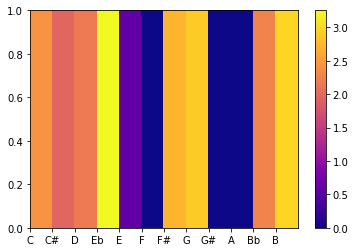

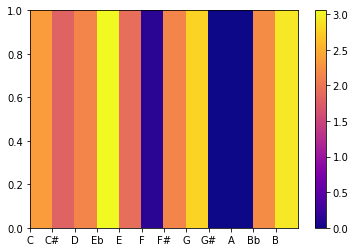

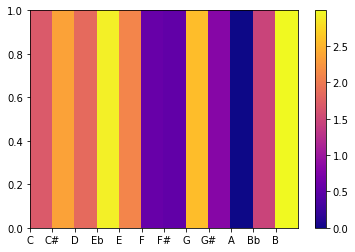

[[ 1.13603707 -0.22540216 -0.07257848  0.09670426 -0.02253448  0.10338855
  -0.06375175  0.07657679  0.1997471  -0.15663451 -0.19080814 -0.02443579]
 [-0.22540216  1.17759837 -0.15073732 -0.1608853   0.04354313  0.14225813
   0.14111046  0.03159931 -0.03770869  0.13572636  0.0850717  -0.02768054]
 [-0.07257848 -0.15073732  1.08238297 -0.22691128 -0.04506145  0.08663644
  -0.03208725  0.11981996 -0.0876083   0.03863677  0.10312307  0.02260598]
 [ 0.09670426 -0.1608853  -0.22691128  1.36473311 -0.28081872 -0.18908087
   0.22936834  0.12473935  0.31893392 -0.1644097   0.20042201 -0.01170684]
 [-0.02253448  0.04354313 -0.04506145 -0.28081872  1.0662722  -0.11933891
  -0.06163974 -0.0113025  -0.02346049  0.22800798 -0.08346969  0.14228911]
 [ 0.10338855  0.14225813  0.08663644 -0.18908087 -0.11933891  1.06171002
  -0.17406538 -0.11322559 -0.02050113  0.09206272  0.22556654  0.01941628]
 [-0.06375175  0.14111046 -0.03208725  0.22936834 -0.06163974 -0.17406538
   1.20693855 -0.17007138  0.011

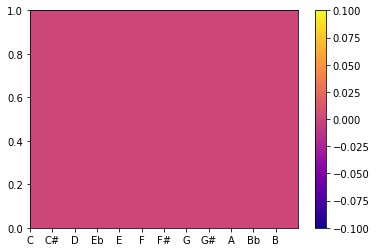

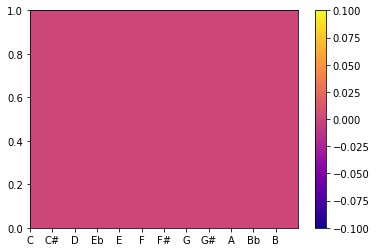

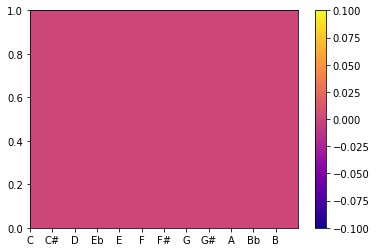

[[ 1.27369653  0.07522437  0.10127566  0.40721255  0.15835973  0.2328009
   0.33492725  0.04890956  0.55569737  0.1107241   0.14956226  0.06732893]
 [ 0.07522437  1.43930197  0.00417383  0.02674473  0.03336087  0.82003664
   0.33833475  0.12966115  0.23170981  0.39147178  0.74056044  0.16615526]
 [ 0.10127566  0.00417383  0.97644096  0.22904124  0.15731068  0.11138614
   0.11194506  0.23096418  0.26471918  0.00962435  0.16382185  0.27864538]
 [ 0.40721255  0.02674473  0.22904124  1.52875954  0.11462756 -0.01084219
   0.33271663  0.38141942  0.42659316  0.12893946  0.40052996 -0.00300805]
 [ 0.15835973  0.03336087  0.15731068  0.11462756  0.96910171  0.05142358
  -0.10146351  0.24073103  0.23808395  0.16172007  0.14135176  0.27931892]
 [ 0.2328009   0.82003664  0.11138614 -0.01084219  0.05142358  1.07584449
   0.15976558  0.07805407  0.37319764  0.32807615  0.54899496  0.25093169]
 [ 0.33492725  0.33833475  0.11194506  0.33271663 -0.10146351  0.15976558
   1.25520167 -0.03065856  0.0038

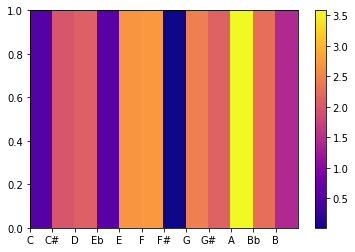

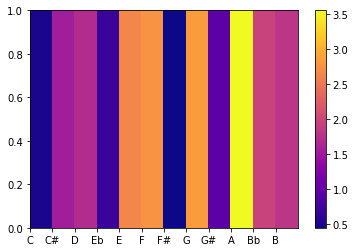

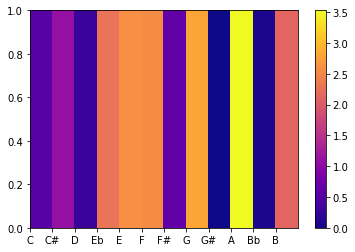

[[ 1.17214243 -0.11113396 -0.14990616  0.16209993  0.07851354  0.08668275
   0.05559349 -0.02354926  0.06831108  0.06138329 -0.04303123 -0.14653557]
 [-0.11113396  1.13671863 -0.24042548  0.02063965  0.02700227  0.18955519
   0.26365098 -0.07080912  0.05612714  0.09018867  0.21376665 -0.08506099]
 [-0.14990616 -0.24042548  1.28547179 -0.30647509 -0.0810326   0.14710155
  -0.1568644   0.28474596 -0.12299434  0.11658891  0.09690666  0.10396707]
 [ 0.16209993  0.02063965 -0.30647509  1.35699952 -0.23558034 -0.22105379
   0.36351019 -0.01765166  0.30028455 -0.10867543  0.20102117 -0.07078684]
 [ 0.07851354  0.02700227 -0.0810326  -0.23558034  1.0903079  -0.12419228
  -0.13787237  0.07177998  0.05553639  0.23306579 -0.06398599  0.08203117]
 [ 0.08668275  0.18955519  0.14710155 -0.22105379 -0.12419228  1.12550586
  -0.20548358 -0.05280812  0.0193275   0.00842365  0.2377079   0.08493846]
 [ 0.05559349  0.26365098 -0.1568644   0.36351019 -0.13787237 -0.20548358
   1.28317563 -0.18360103  0.037

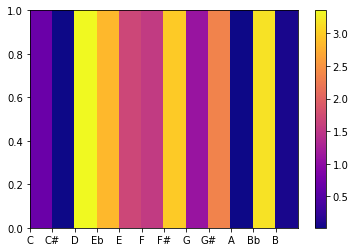

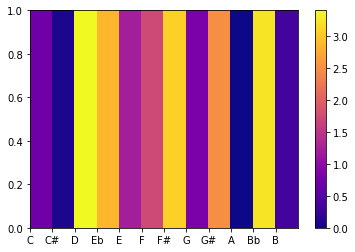

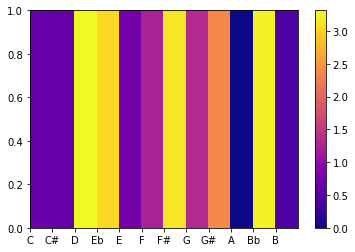

[[ 1.32475573 -0.17830054 -0.11228031  0.17891782 -0.04329972  0.30504391
  -0.05191666  0.10048325  0.24652764 -0.12091638 -0.08557097 -0.06299709]
 [-0.17830054  1.12519169 -0.13451998 -0.08367842  0.20023443  0.16952655
   0.11158715  0.08570134  0.05841303  0.20186969  0.05486735  0.00220931]
 [-0.11228031 -0.13451998  1.35598076 -0.1241476  -0.18359991  0.1087334
   0.03599953  0.16370686 -0.07916696  0.05910513  0.26884176 -0.02026004]
 [ 0.17891782 -0.08367842 -0.1241476   1.37669621 -0.28101175 -0.08989023
   0.04817226  0.01483718  0.39954303 -0.23097566  0.20454878 -0.07782455]
 [-0.04329972  0.20023443 -0.18359991 -0.28101175  1.23234795 -0.13597392
   0.05594292  0.00759395  0.1401196   0.42182411 -0.0581084   0.26841535]
 [ 0.30504391  0.16952655  0.1087334  -0.08989023 -0.13597392  1.18667241
  -0.1581192   0.01117909 -0.0200635  -0.02100525  0.23769756  0.06909658]
 [-0.05191666  0.11158715  0.03599953  0.04817226  0.05594292 -0.1581192
   1.12868863 -0.09434542 -0.01647

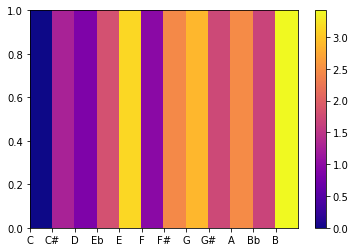

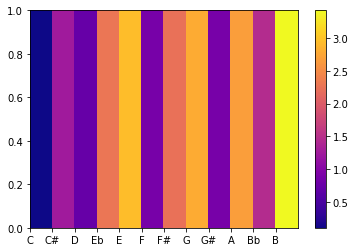

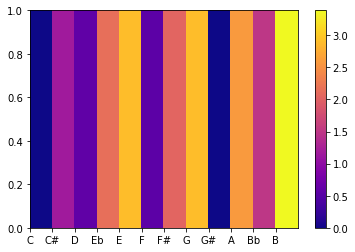

[[ 1.16458934 -0.13372451 -0.16899998  0.03409545  0.00139072  0.0677045
   0.05397266 -0.11808317  0.14493136 -0.11427752 -0.00773371 -0.20902409]
 [-0.13372451  1.1123895  -0.35368959 -0.10702382 -0.02829319  0.17607055
   0.0721036  -0.0096824  -0.04743061  0.12680164 -0.00915539  0.00380516]
 [-0.16899998 -0.35368959  1.24885705 -0.27613176 -0.04446323 -0.08314583
  -0.22990664  0.23272025 -0.07051974 -0.03428693  0.1521042  -0.15724648]
 [ 0.03409545 -0.10702382 -0.27613176  1.16819799 -0.13779819 -0.14880273
   0.20188295 -0.14482908  0.19247453 -0.1613288  -0.02388494  0.02572522]
 [ 0.00139072 -0.02829319 -0.04446323 -0.13779819  1.10056841 -0.38532912
  -0.14524209  0.19655443 -0.06055415  0.08258524  0.14020419  0.02559421]
 [ 0.0677045   0.17607055 -0.08314583 -0.14880273 -0.38532912  1.22629403
  -0.18337286 -0.30814036  0.10867314  0.09260033  0.01808835 -0.07699499]
 [ 0.05397266  0.0721036  -0.22990664  0.20188295 -0.14524209 -0.18337286
   1.19349658 -0.28111137 -0.0759

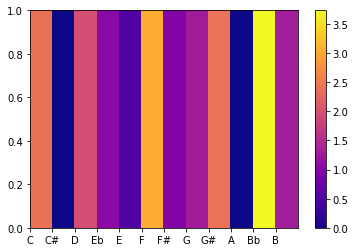

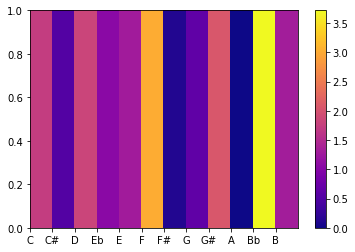

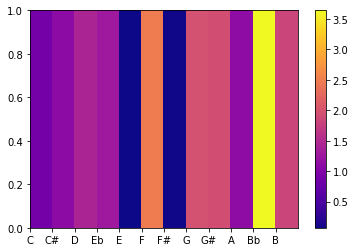

[[ 1.22020072 -0.14177499 -0.10672844  0.05914654  0.00528864  0.14031798
   0.00653939  0.00777619  0.24729566 -0.03565281 -0.20282558 -0.11480559]
 [-0.14177499  1.1234702  -0.19106576 -0.08187443  0.01197702  0.1977325
   0.11741697  0.00294027  0.05060179  0.10088691  0.13553002 -0.07806781]
 [-0.10672844 -0.19106576  1.15388143 -0.25053121 -0.04840291  0.06109001
   0.03383832  0.14786139 -0.1132529   0.11925589  0.03223513  0.08231628]
 [ 0.05914654 -0.08187443 -0.25053121  1.35878088 -0.30934762 -0.19047264
   0.03350394  0.09277489  0.37908649 -0.12693507  0.21907543 -0.06188208]
 [ 0.00528864  0.01197702 -0.04840291 -0.30934762  1.15709949 -0.1009112
  -0.03835855 -0.02861029 -0.02274992  0.21961842 -0.07901632  0.1643779 ]
 [ 0.14031798  0.1977325   0.06109001 -0.19047264 -0.1009112   1.09837294
  -0.14567165 -0.10800743  0.05155836 -0.02781967  0.17610071  0.03036896]
 [ 0.00653939  0.11741697  0.03383832  0.03350394 -0.03835855 -0.14567165
   1.17671098 -0.12778688 -0.10986

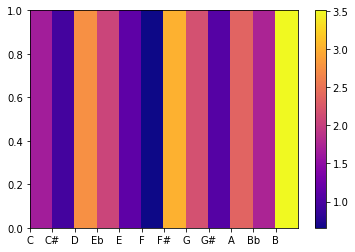

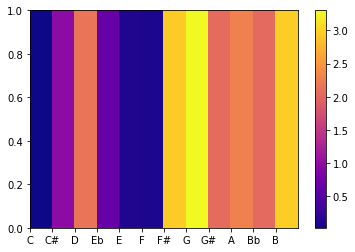

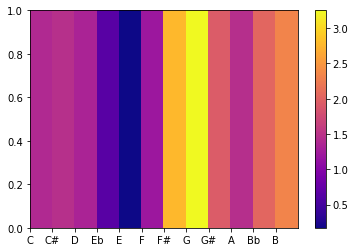

[[ 9.65996328e-01 -9.87201035e-02  2.37261946e-02  2.59266343e-01
  -1.88705047e-01  1.00121509e-01  2.05736260e-01 -2.22587653e-01
   2.80183705e-01  7.86209280e-03 -1.21140594e-03 -1.19062886e-01]
 [-9.87201035e-02  1.16905738e+00 -3.51548637e-01 -1.16759802e-01
  -1.26526600e-01  3.53670229e-01  1.55206513e-01 -8.56487109e-02
  -2.94394808e-02  1.71399498e-01  3.29044549e-01 -1.04169734e-01]
 [ 2.37261946e-02 -3.51548637e-01  9.31998086e-01 -9.16754315e-02
   1.37390053e-01  5.47319980e-02 -1.18499601e-01  1.78480510e-01
   7.29448941e-02  3.12971771e-02 -3.57916976e-02  1.37579066e-01]
 [ 2.59266343e-01 -1.16759802e-01 -9.16754315e-02  1.16344811e+00
  -2.74575496e-01 -2.06651352e-01  2.70757698e-01 -4.83466970e-03
   2.57540013e-01 -1.90679278e-01  1.77486068e-01 -1.54033114e-01]
 [-1.88705047e-01 -1.26526600e-01  1.37390053e-01 -2.74575496e-01
   1.16789213e+00 -1.63969560e-01 -1.93120817e-01  2.31949322e-01
   4.10892603e-02  1.61437462e-01 -1.30283195e-01  1.22105618e-01]
 [ 1.

In [175]:
for note in range(12):
    note_names = ['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B']
    print(note_names[note])
    idx = np.where(y == note)[0]
    
    X_idx = np.take(X, idx, axis=0)
    print(X_idx[0].shape)
    mean = np.mean(X_idx, axis=0)
    for trials in range(3):
        plt.pcolormesh([X_idx[trials]], cmap='plasma')
        plt.xticks(np.arange(12), ['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B'])
        plt.colorbar()
        plt.show()
        
    print(np.cov(X_idx.T))



## Transition matrix

### Made from bigrams from annotations

## Label features

### Label according to closest chord template vector

`obs` observation array containing index for closest chord vector (Take 3 songs from index 17 to 19)


Initialize random matrices for HMM

In [5]:
# Construct chord vectors

note_names = ['C','C#','D','Eb','E','F','F#','G','G#','A','Bb','B']
qualities = ['major', 'minor']
chord_names = [note + ' ' + qualities[0] for note in note_names] + [note + ' ' + qualities[1] for note in note_names]

# Row for each major chord
C = np.zeros((24,12))
for bass_note in range(12):
    # prime
    C[bass_note, bass_note] = 1
    C[bass_note + 12, bass_note] = 1
    # third
    C[bass_note, (bass_note + 4)%12] = 1
    C[bass_note + 12, (bass_note + 3)%12] = 1

chords = [{
    "name" : chord_names[i],
    "index" : i,
    "template" : C[i]
} for i in range(24)]

In [6]:
N = X.shape[0]
obs = []
for i in range(0,starting_points[3]):
    obs.append(int(np.argmax(C@X[i,:].T)))

In [ ]:
A, B, pi = random_model(24,24)
A, B, pi, olp, _ = b_w(A,B,pi,obs[:starting_points[2]])



In [11]:
from hmm2 import viterbi

path = viterbi(A,B,pi,obs[starting_points[2]:starting_points[3]])

['Bb major',
 'G major',
 'G major',
 'G major',
 'A major',
 'C minor',
 'C# major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'C# minor',
 'F# minor',
 'G major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',
 'F major',
 'E major',


## Use KMeans to cluster chroma vectors



In [21]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=12, random_state=19).fit(X_small)



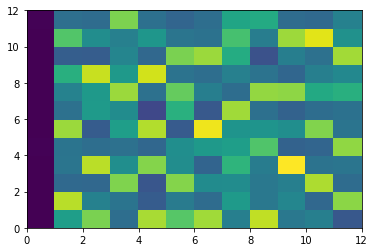

In [22]:
plt.pcolormesh(clusters.cluster_centers_.T)